In [56]:
# asume que los datos estan en ../data/<año>.csv.bz2
# fixme: poner el directorio de data que esté en el repo cuando pusheen los pibes

import seaborn as sns
import matplotlib.pyplot as plt

import fnmatch

import pandas as pd
import time
import os
import shutil
#sns.set(color_codes=True)

# load data
tmp_dir = "./tmp_csv/"
years = [str(year) for year in range(1994,1999)]

## Procesar datos

In [60]:
#crear directorio con data de delays agrupada por retraso 
if not os.path.exists(tmp_dir):
    os.makedirs(tmp_dir)
    
for year in years:
    if not os.path.exists(tmp_dir+year+".csv"):
        print("Leyendo csv: {}".format(year))
        t = time.time()
        df = pd.read_csv("../data/"+year+".csv.bz2", compression="bz2", usecols=["Month", "Year", "DayofMonth", "DayOfWeek", "DepDelay", "ArrDelay"], encoding="ISO 8859-1")    

        #formato mas feliz para fechas
        dates = pd.to_datetime(df.Year*10000+df.Month*100+df.DayofMonth,format='%Y%m%d')
        df["date"] = dates
        df = df[["date", "Year", "DepDelay", "ArrDelay"]]

        df = df.groupby(by=df['date'].dt.date).mean()
        df.to_csv(tmp_dir+year+".csv")
        del df 
    

Leyendo csv: 1994
Leyendo csv: 1995
Leyendo csv: 1996
Leyendo csv: 1997
Leyendo csv: 1998


1998.csv


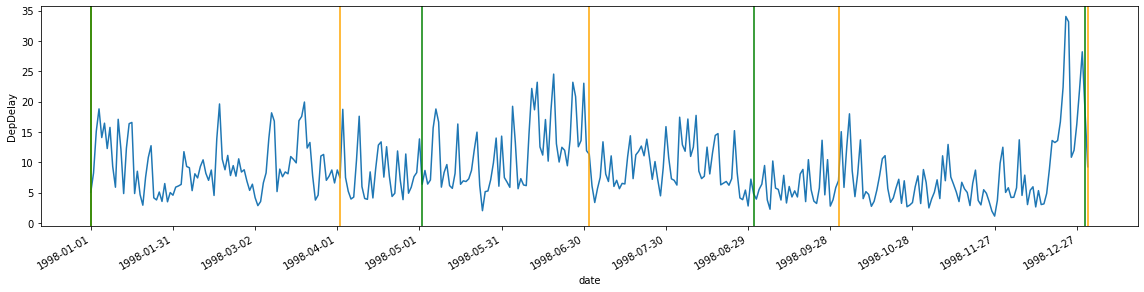

1996.csv


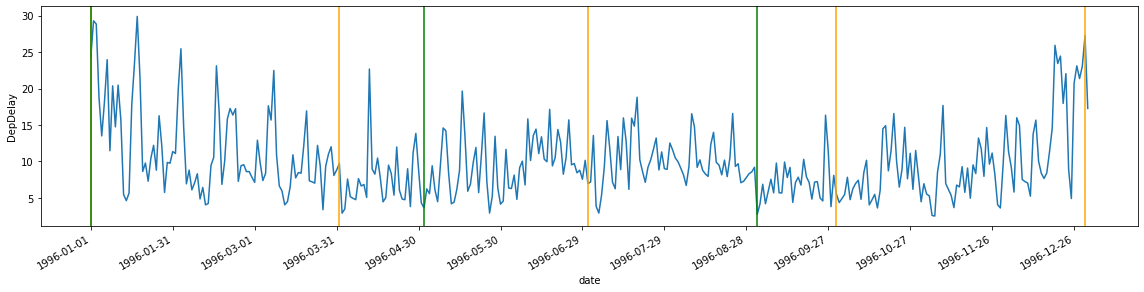

1994.csv


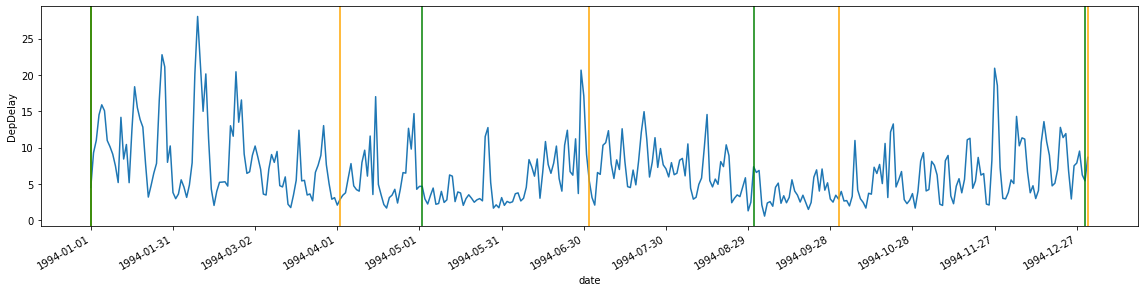

1997.csv


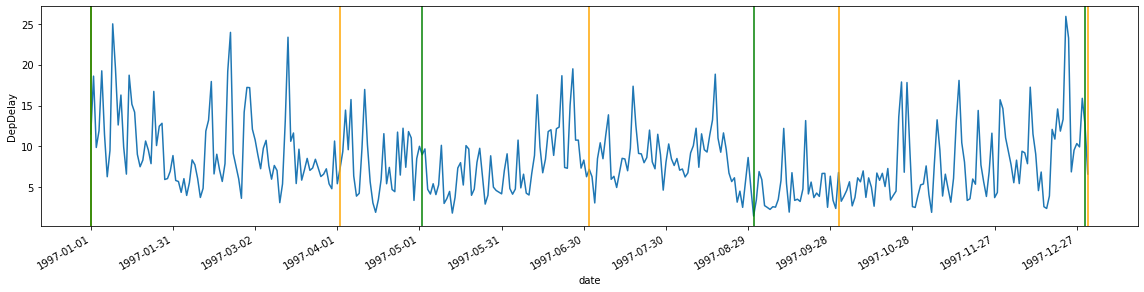

1995.csv


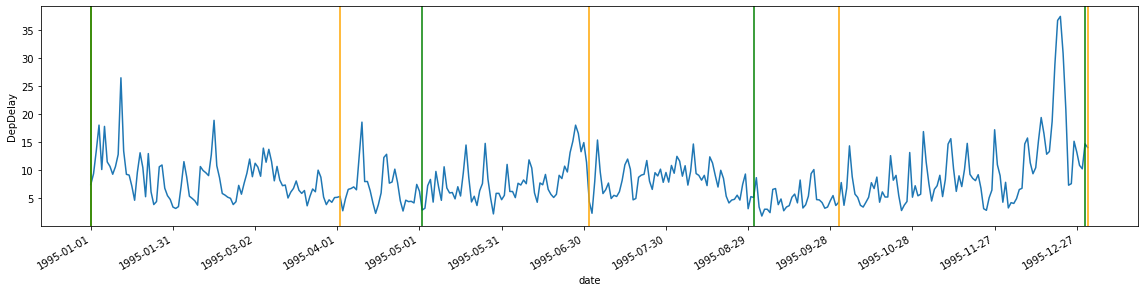

In [61]:
for filename in os.listdir(tmp_dir):
    if filename.endswith(".csv") and filename != "merged.csv": 
        print(filename)
        df = pd.read_csv(tmp_dir+filename)
        fig, ax = plt.subplots(figsize=(16,4))
        sns.lineplot(x=df.date, y=df.DepDelay, linestyle='-')
        plt.xticks(plt.xticks()[0], df.date, rotation=90)
        plt.tight_layout()
        xticks = ax.xaxis.get_major_ticks()
        for i in range(len(xticks)):
            if i%30 != 0:
                xticks[i].set_visible(False)
            if i%int((len(xticks))/4) == 0:    
                plt.axvline(x=i, color="orange")
            if i%int((len(xticks))/3) == 0:    
                plt.axvline(x=i, color="green")
        fig.autofmt_xdate()
        plt.show()
        
#Trimestres en verde, cuatrimestres en naranja

In [62]:
#merge
df = pd.DataFrame(columns=["date", "DepDelay", "ArrDelay"])
for filename in sorted(os.listdir(tmp_dir)):
    if filename.endswith(".csv") and filename != "merged.csv":
        print(filename)
        df_input = pd.read_csv(tmp_dir+filename)
        df = pd.concat([df, df_input], sort=True)
        
df.set_index('date')
df.to_csv(tmp_dir+"merged.csv")

1994.csv
1995.csv
1996.csv
1997.csv
1998.csv


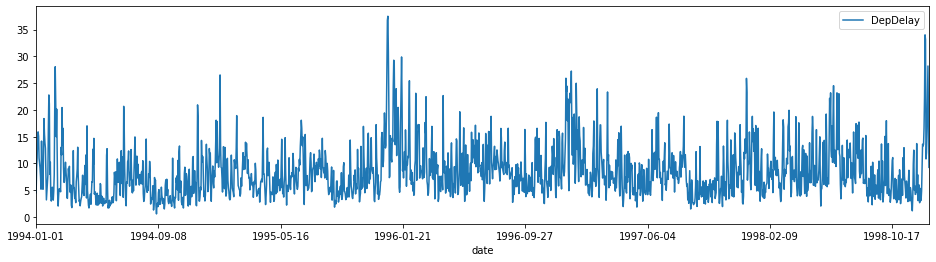

In [63]:
df = pd.read_csv(tmp_dir+"merged.csv")
df.plot(x="date", y="DepDelay", linestyle='-', figsize=(16,4))

## CML acá 

In [101]:
#delays = df["DepDelay"]
old_delays = df.loc[df["Year"]<1998]["DepDelay"]
print(old_delays)
print(df["DepDelay"])

0        4.536299
1        9.299748
2       11.008509
3       14.519623
4       15.904900
          ...    
1456    10.356488
1457     9.948160
1458    15.885614
1459    12.674758
1460     6.637504
Name: DepDelay, Length: 1461, dtype: float64
0        4.536299
1        9.299748
2       11.008509
3       14.519623
4       15.904900
          ...    
1821    16.286306
1822    21.970887
1823    28.202133
1824    18.458698
1825     9.279752
Name: DepDelay, Length: 1826, dtype: float64


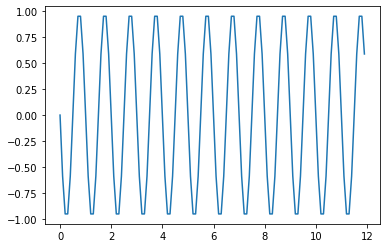

In [82]:
#para jugar con fases
time        = np.arange(0, 12,0.1);
amplitude   = np.sin(2 * math.pi / 1* time + math.pi)
plt.plot(time, amplitude)
plt.show()

In [135]:
import numpy as np
import math

max_grade = 1
phases = [i*math.pi/2 for i in range(4)]

# semanas, meses, bimestres, trimestres, cuatrimestres, semestres, años
freqs =  [7] + [355/i for i in [12, 6, 4, 3, 2, 1]]

def trig_vals(t):
    return  [math.sin(2 * math.pi / f * t + p) for f in freqs for p in phases]

def get_x_vals(x):
    x_vals = []
    for i in range(len(x)):
        row = np.array([i**p for p in range(max_grade+1)] + trig_vals(i), dtype='float')
        x_vals.append(row)
    return x_vals

arrays = get_x_vals(old_delays)
A = np.stack(arrays)
print(A.shape)

#coefs = np.linalg.lstsq(A, old_delays, rcond=None)[0]
coefs = np.linalg.solve(A.T@A, A.T@old_delays)

(1461, 30)


In [136]:
del df["dl_pred"]

In [137]:
full_delays = df["DepDelay"]
full_arrays = get_x_vals(full_delays)
full_A = np.stack(full_arrays)

df["dl_pred"] = full_A@coefs 
df

,Unnamed: 0,ArrDelay,DepDelay,Year,date,dl_pred
0,0,1.777870,4.536299,1994.0,1994-01-01,9.486777
1,1,7.971149,9.299748,1994.0,1994-01-02,8.534004
2,2,11.952367,11.008509,1994.0,1994-01-03,8.108006
3,3,14.939042,14.519623,1994.0,1994-01-04,8.619934
4,4,16.644046,15.904900,1994.0,1994-01-05,9.776489
...,...,...,...,...,...,...
1821,360,12.774995,16.286306,1998.0,1998-12-27,12.016632
1822,361,19.859677,21.970887,1998.0,1998-12-28,11.414254
1823,362,27.701600,28.202133,1998.0,1998-12-29,11.743724
1824,363,17.107503,18.458698,1998.0,1998-12-30,12.708742


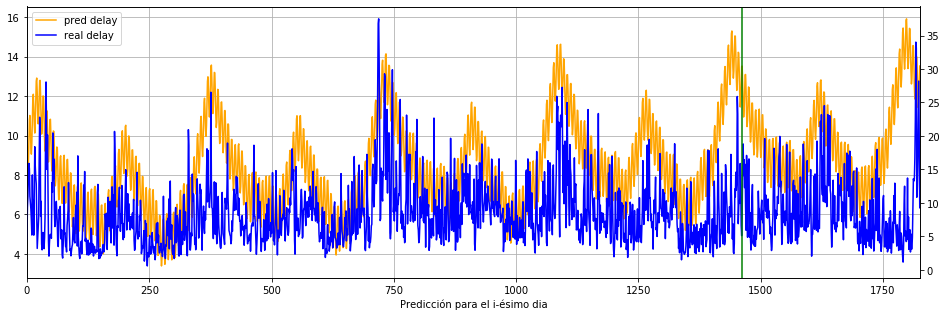

In [138]:
plt.figure(figsize=(16,5))
plt.xlabel('Predicción para el i-ésimo dia')


ax1 = df.dl_pred.plot(color='orange', grid=True, label='pred delay')
ax2 = df.DepDelay.plot(color='blue', grid=True, secondary_y=True, label='real delay')

xticks = ax1.xaxis.get_major_ticks()
plt.axvline(x=len(old_delays), color="green")

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()

plt.legend(h1+h2, l1+l2, loc=2)
plt.show()

## BORRAR ARCHIVOS

In [52]:
#borrar aux de años
for filename in os.listdir(tmp_dir):
    if fnmatch.fnmatch(filename, '*.csv') and filename != "merged.csv":
        os.remove(tmp_dir+filename)

In [54]:
#borrar merged
os.remove(tmp_dir+"merged.csv")

FileNotFoundError: [Errno 2] No such file or directory: './tmp_csv/merged.csv'

In [55]:
#borrar tmp
shutil.rmtree(tmp_dir)